### Explanation of the new class NNRegressor

The class `NNRegressor` is defined in `regressors.py`. It is essentially a wrapper around a pytorch model that makes it compatible with scikit pipelines. Here is how to use it.

The `__init__` method of an `NNRegressor` instance takes in input:

* `model_class`: a pytorch model class (such as for example `ConvNN` contained in `models.py`);

* `model_parameters`: a dictionary containing the keyword arguments to be passed to `model_class` whenever the model is initialized;

* `loss_fnc`: a dictionary of named loss functions, taking in input numpy arrays and returning numbers; practically, this will always be `{'RMSE': RMSE, 'NMSE': NMSE}` where `RMSE, NMSE` are imported from `validation.py`

* `batch_size`, `learning_rate`, `max_epochs`, `patience`: these are pretty self-explanatory hyperparameters that are used to train the model.

Any instance of `NNRegressor` has three methods:
* `.fit`: takes in input a pair `(X,y)` of NUMPY arrays. The shape depends on the particular model class we are using, but we DO NOT pass the data split into sessions.

For example, in the case of `ConvNN` which works directly with time windows, `X` will have shape `(N, 8, 500)`, while `y` will have shape `(N, 51)`. `.fit` returns the `self` instance of `NNRegressor` (NOT the pytorch model!).

The "best" weights and biases of the neural network are internally saved in the attribute `.best_model` of the `NNRegressor` instance. In this case, "best" means that I take the weights and biases with lowest TRAINING loss function (that's the only way I could think of to avoid leakage).

The `patience` hyperparameter sets a possible early exit: if at training time the training loss is not improved in `patience` epochs, the training loop ends early.

* `.predict`: takes in input a NUMPY array `X` of the same shape of the `X` taken in input by `.fit`, and returns the predicted values of the model which uses the best weights and biases obtained at training time (for this reason, calling `.predict` before calling `.fit` or `.fit_with_validation` will throw an exception because `.best_model` is initialized to `None`).

* `.fit_with_validation`: this is a custom method which is not used by scikit pipelines, but is useful for us for architecture selection and hyperparameter tuning. This guy takes in input `(X_train, y_train, X_val, y_val)` which are NUMPY arrays of shape respectively `(N_train, ...), (N_train, 51), (N_val, ...), (N_val, 51)`.

This methods trains exactly the same model obtained by calling `.fit(X_train, y_train)`; however, it also computes and prints the average batch validation loss on the unseen data `(X_val, y_val)`.

Finally, this method returns a tuple `(train_losses, val_losses)` of numpy array of length equal to the number of epochs (which cannot exceed `max_epochs`, but can be smaller if the training loop exits earlier because of the patience mechanism).

### Explanation of the validation function cross_validate_NN

This function is in `validation.py` and it works similarly to `cross_validate_pipeline`. It takes in input an instance of `NNRegressor`, and the parameters `X_folds`, `Y_folds`, `metric_fns`, `n_folds`, `verbose` exactly as `cross_validate_pipeline`. So, in this case, `X_folds` and `Y_folds` are split into sessions.

For example, if the model we used to initialize our `NNRegressor` is `ConvNN`, the input of the `.fit` method should be a pair `X,y` with shape `(N, 8, 500)` and `(N, 51)` respectively. Therefore, the parameters `X_folds` and `Y_folds` of `cross_validate_NN` sholuld have shape `(n_folds, M, 8, 500)` and `(n_folds, M, 51)` respectively. `n_folds` is set to 4 by default, but it should be equal to the first dimension of `X_folds` and `Y_folds`.

The parameter `verbose` can take values 0,1,2,3. If we set it to 0,1,2 it does exactly the same that `cross_validate_pipeline` does. If we set it to `3`, the instance of `NNRegressor` calls `.fit_with_validation` rather than `.fit`, and therefore all the validation results are printed out, included the graphs showing the learning curves per fold.

This is easier to use than to explain!

# Testing NN models

In [2]:
import numpy as np

from config.transformers import TimeWindowTransformer, LabelWindowExtractor

from config.regressors import NNRegressor
from config.loss_functions import RMSELoss
from config.models import ConvNN

from config.validation import RMSE, NMSE, cross_validate_NN

In [3]:
PATH = f'/Users/marco/PROJECTS/data/'
# PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'freemoves' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

tw_extractor = TimeWindowTransformer(size = 500, step = 100)
label_extractor = LabelWindowExtractor(size = 500, step = 100)

X_windows = tw_extractor.transform(X)
Y_labels = label_extractor.transform(Y)

train_val_idx = [0,1,2,3]
test_idx = 4

X_train_val_folds = X_windows[train_val_idx]
Y_train_val_folds = Y_labels[train_val_idx]

X_test = X_windows[test_idx]
Y_test = Y_labels[test_idx]

FOLD 1/4
Epoch 001 | Train Loss: 25.2855 | Val Loss: 20.0514 | 
Epoch 002 | Train Loss: 19.4498 | Val Loss: 14.6584 | 
Epoch 003 | Train Loss: 13.8122 | Val Loss: 11.6909 | 
Epoch 004 | Train Loss: 10.9321 | Val Loss: 11.6726 | 
Epoch 005 | Train Loss: 10.1701 | Val Loss: 11.1946 | 
Epoch 006 | Train Loss: 9.7342 | Val Loss: 9.8681 | 
Epoch 007 | Train Loss: 9.4665 | Val Loss: 12.3687 | 
Epoch 008 | Train Loss: 9.4115 | Val Loss: 10.5207 | 
Epoch 009 | Train Loss: 9.2639 | Val Loss: 11.1854 | 
Epoch 010 | Train Loss: 9.1266 | Val Loss: 9.8543 | 
Epoch 011 | Train Loss: 9.1029 | Val Loss: 10.3279 | 
Epoch 012 | Train Loss: 8.8993 | Val Loss: 10.2230 | 
Epoch 013 | Train Loss: 8.8009 | Val Loss: 10.4621 | 
Epoch 014 | Train Loss: 8.7889 | Val Loss: 9.9305 | 
Epoch 015 | Train Loss: 8.7416 | Val Loss: 9.7579 | 
Epoch 016 | Train Loss: 8.6155 | Val Loss: 9.8575 | 
Epoch 017 | Train Loss: 8.5278 | Val Loss: 10.0277 | 
Epoch 018 | Train Loss: 8.4859 | Val Loss: 9.7634 | 
Epoch 019 | Train Lo

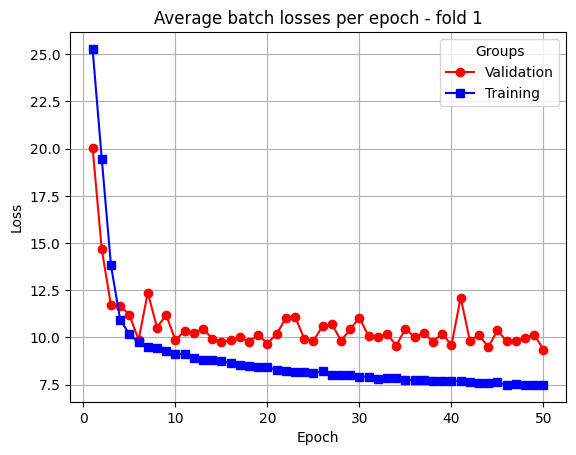

FOLD 2/4
Epoch 001 | Train Loss: 22.8817 | Val Loss: 25.3246 | 
Epoch 002 | Train Loss: 17.4659 | Val Loss: 21.9180 | 
Epoch 003 | Train Loss: 12.4509 | Val Loss: 15.6574 | 
Epoch 004 | Train Loss: 10.0921 | Val Loss: 14.8630 | 
Epoch 005 | Train Loss: 9.3363 | Val Loss: 14.9534 | 
Epoch 006 | Train Loss: 9.0183 | Val Loss: 15.0221 | 
Epoch 007 | Train Loss: 8.7743 | Val Loss: 13.4516 | 
Epoch 008 | Train Loss: 8.6352 | Val Loss: 13.9946 | 
Epoch 009 | Train Loss: 8.4365 | Val Loss: 13.8183 | 
Epoch 010 | Train Loss: 8.3022 | Val Loss: 15.1211 | 
Epoch 011 | Train Loss: 8.2138 | Val Loss: 13.3850 | 
Epoch 012 | Train Loss: 8.1510 | Val Loss: 13.9705 | 
Epoch 013 | Train Loss: 8.1305 | Val Loss: 14.0082 | 
Epoch 014 | Train Loss: 7.9926 | Val Loss: 14.4510 | 
Epoch 015 | Train Loss: 7.8897 | Val Loss: 13.5899 | 
Epoch 016 | Train Loss: 7.8566 | Val Loss: 13.9000 | 
Epoch 017 | Train Loss: 7.8439 | Val Loss: 14.3719 | 
Epoch 018 | Train Loss: 7.7298 | Val Loss: 14.2452 | 
Epoch 019 | Tra

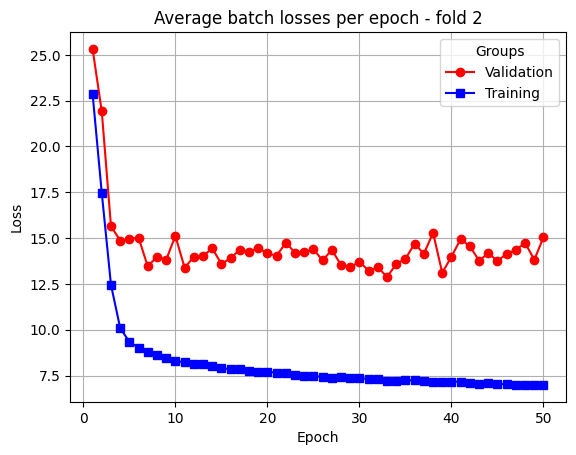

FOLD 3/4
Epoch 001 | Train Loss: 24.7174 | Val Loss: 20.8486 | 
Epoch 002 | Train Loss: 18.8696 | Val Loss: 14.9755 | 
Epoch 003 | Train Loss: 13.4696 | Val Loss: 11.8858 | 
Epoch 004 | Train Loss: 10.6954 | Val Loss: 11.9021 | 
Epoch 005 | Train Loss: 9.9563 | Val Loss: 11.0061 | 
Epoch 006 | Train Loss: 9.4475 | Val Loss: 10.4342 | 
Epoch 007 | Train Loss: 9.2987 | Val Loss: 10.5660 | 
Epoch 008 | Train Loss: 9.1252 | Val Loss: 10.5581 | 
Epoch 009 | Train Loss: 8.9502 | Val Loss: 10.3781 | 
Epoch 010 | Train Loss: 8.8363 | Val Loss: 10.6600 | 
Epoch 011 | Train Loss: 8.7408 | Val Loss: 10.9308 | 
Epoch 012 | Train Loss: 8.7762 | Val Loss: 10.6703 | 
Epoch 013 | Train Loss: 8.5767 | Val Loss: 10.4634 | 
Epoch 014 | Train Loss: 8.6142 | Val Loss: 10.7796 | 
Epoch 015 | Train Loss: 8.4763 | Val Loss: 10.6525 | 
Epoch 016 | Train Loss: 8.4558 | Val Loss: 12.2654 | 
Epoch 017 | Train Loss: 8.3387 | Val Loss: 11.2912 | 
Epoch 018 | Train Loss: 8.3370 | Val Loss: 13.4806 | 
Epoch 019 | Tra

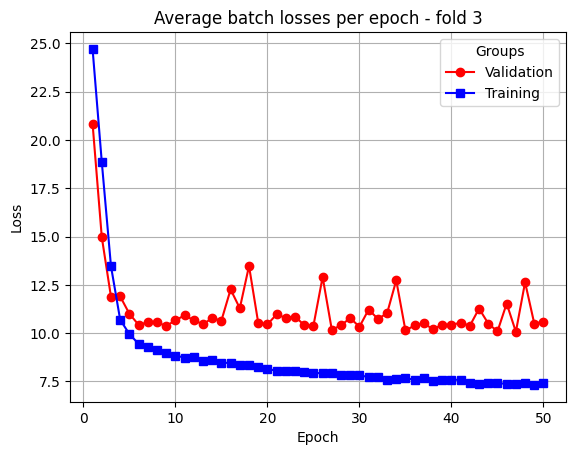

FOLD 4/4
Epoch 001 | Train Loss: 25.6505 | Val Loss: 19.3405 | 
Epoch 002 | Train Loss: 19.7661 | Val Loss: 15.1994 | 
Epoch 003 | Train Loss: 14.1879 | Val Loss: 10.9508 | 
Epoch 004 | Train Loss: 11.2445 | Val Loss: 9.9090 | 
Epoch 005 | Train Loss: 10.2398 | Val Loss: 9.2678 | 
Epoch 006 | Train Loss: 9.8519 | Val Loss: 8.9168 | 
Epoch 007 | Train Loss: 9.5849 | Val Loss: 9.3107 | 
Epoch 008 | Train Loss: 9.3673 | Val Loss: 8.7143 | 
Epoch 009 | Train Loss: 9.3013 | Val Loss: 9.3431 | 
Epoch 010 | Train Loss: 9.2206 | Val Loss: 8.8463 | 
Epoch 011 | Train Loss: 9.0370 | Val Loss: 9.8578 | 
Epoch 012 | Train Loss: 8.9865 | Val Loss: 9.0456 | 
Epoch 013 | Train Loss: 8.8350 | Val Loss: 8.4903 | 
Epoch 014 | Train Loss: 8.8525 | Val Loss: 8.7076 | 
Epoch 015 | Train Loss: 8.7686 | Val Loss: 8.4469 | 
Epoch 016 | Train Loss: 8.8067 | Val Loss: 8.4170 | 
Epoch 017 | Train Loss: 8.5597 | Val Loss: 8.4411 | 
Epoch 018 | Train Loss: 8.5511 | Val Loss: 8.3878 | 
Epoch 019 | Train Loss: 8.473

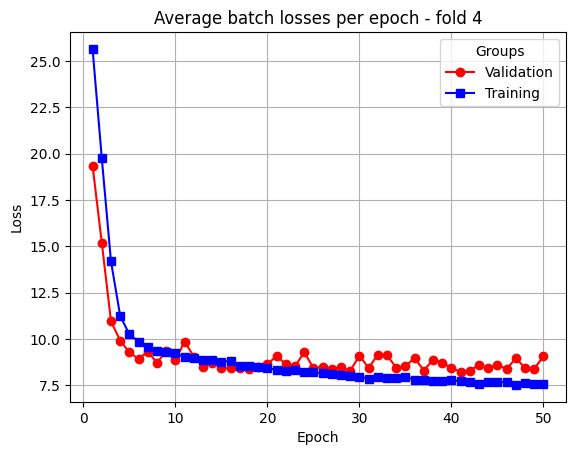


Average Scores across folds:
RMSE: train=6.9880, val=12.2181
NMSE: train=0.2970, val=1.0141


In [4]:
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 50,
    patience = 10
)

results = cross_validate_NN(
    my_NNRegressor,
    X_train_val_folds,
    Y_train_val_folds,
    metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
    verbose=3)

In [5]:
# test on unseen data

# initialize the model
my_NNRegressor = NNRegressor(
    model_class=ConvNN,
    model_parameters={'end_dim': 51},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 50,
    patience = 10
)

# train on the first four sessions
X_train = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

my_NNRegressor.fit(X_train, Y_train)

# compute the prediction of the fifth session
Y_test_pred = my_NNRegressor.predict(X_test)

# compute the errors
print(RMSE(Y_test_pred, Y_test))
print(NMSE(Y_test_pred, Y_test))

KeyboardInterrupt: 

### Designing new models

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [157]:
class ConvNN2(nn.Module):
    def __init__(self,
                 in_channels=8,
                 time_feats=32,
                 spat_feats=16,
                 kernel_size=15,
                 fc_hidden=128,
                 output_dim=51,
                 conv_dropout=0.2,
                 fc_dropout=0.5):
        super().__init__()
        pad = kernel_size // 2

        # 1) Temporal Block
        self.temp1_conv = nn.Conv1d(in_channels, time_feats,
                                    kernel_size, padding=pad)
        self.temp1_bn   = nn.BatchNorm1d(time_feats)
        self.temp1_pool = nn.AvgPool1d(2)
        self.temp1_drop = nn.Dropout(conv_dropout)

        # 2) Spatial Block
        self.spat_conv  = nn.Conv2d(1, spat_feats, 
                                    kernel_size=(in_channels,1))
        self.spat_bn    = nn.BatchNorm2d(spat_feats)
        self.spat_pool  = nn.AvgPool2d((1,2))
        self.spat_drop  = nn.Dropout2d(conv_dropout)

        # 3) Second Temporal Block
        total_feats     = time_feats + spat_feats
        self.temp2_conv = nn.Conv1d(total_feats, total_feats,
                                    kernel_size, padding=pad)
        self.temp2_bn   = nn.BatchNorm1d(total_feats)
        self.temp2_pool = nn.AdaptiveAvgPool1d(1)
        self.temp2_drop = nn.Dropout(conv_dropout)

        # 4) Fully‐connected head
        self.fc1        = nn.Linear(total_feats, fc_hidden)
        self.fc1_drop   = nn.Dropout(fc_dropout)
        self.fc2        = nn.Linear(fc_hidden, fc_hidden)
        self.fc3        = nn.Linear(fc_hidden, output_dim)

    def forward(self, x):
        """
        x: (N, 8, 500)
        returns: (N, 51)
        """
        # --- Block 1: Temporal ---
        t = self.temp1_conv(x)            # → (N, time_feats, 500)
        t = self.temp1_bn(t)
        t = F.relu(t)
        t = self.temp1_pool(t)            # → (N, time_feats, 250)
        t = self.temp1_drop(t)
        t_skip = F.interpolate(x, scale_factor=0.5, mode='linear',
                               align_corners=False)
        # pad skip if needed
        if t_skip.size(1) < t.size(1):
            pad_feat = t.size(1) - t_skip.size(1)
            t_skip = F.pad(t_skip, (0,0,0,pad_feat))
        t = t + t_skip                     # residual

        # --- Block 2: Spatial on original ---
        s = x.unsqueeze(1)                 # → (N,1,8,500)
        s = self.spat_conv(s)              # → (N,spat_feats,1,500)
        s = self.spat_bn(s)
        s = F.relu(s)
        s = self.spat_pool(s)              # → (N,spat_feats,1,250)
        s = self.spat_drop(s)
        s = s.squeeze(2)                   # → (N,spat_feats,250)

        # --- Merge and Block 3: Temporal 2 ---
        y = torch.cat([t, s], dim=1)       # → (N, total_feats, 250)
        y = self.temp2_conv(y)
        y = self.temp2_bn(y)
        y = F.relu(y)
        y = self.temp2_drop(y)
        y = self.temp2_pool(y).squeeze(-1) # → (N, total_feats)

        # --- FC Head ---
        y = F.relu(self.fc1(y))
        y = self.fc1_drop(y)
        y = F.relu(self.fc2(y))
        return self.fc3(y)                 # → (N, 51)

    def build(self):
        # compatibility stub
        return self


In [158]:
model = ConvNN2()

x = torch.zeros(1000, 8, 500)

model(x).shape

torch.Size([1000, 51])

FOLD 1/4
Epoch 001 | Train Loss: 15.8409 | Val Loss: 11.6202 | 
Epoch 002 | Train Loss: 12.1066 | Val Loss: 11.9186 | 
Epoch 003 | Train Loss: 11.9684 | Val Loss: 11.5281 | 
Epoch 004 | Train Loss: 11.6698 | Val Loss: 11.4500 | 
Epoch 005 | Train Loss: 11.4037 | Val Loss: 11.2690 | 
Epoch 006 | Train Loss: 11.2271 | Val Loss: 11.0597 | 
Epoch 007 | Train Loss: 11.0933 | Val Loss: 10.8224 | 
Epoch 008 | Train Loss: 10.8672 | Val Loss: 10.6095 | 
Epoch 009 | Train Loss: 10.6847 | Val Loss: 10.6743 | 
Epoch 010 | Train Loss: 10.5379 | Val Loss: 10.3874 | 
Epoch 011 | Train Loss: 10.5329 | Val Loss: 10.4093 | 
Epoch 012 | Train Loss: 10.3728 | Val Loss: 10.4308 | 
Epoch 013 | Train Loss: 10.3108 | Val Loss: 10.4132 | 
Epoch 014 | Train Loss: 10.2758 | Val Loss: 10.4506 | 
Epoch 015 | Train Loss: 10.2671 | Val Loss: 10.2366 | 
Epoch 016 | Train Loss: 10.2390 | Val Loss: 10.3165 | 
Epoch 017 | Train Loss: 10.1099 | Val Loss: 10.4255 | 
Epoch 018 | Train Loss: 9.9379 | Val Loss: 10.1104 | 
Ep

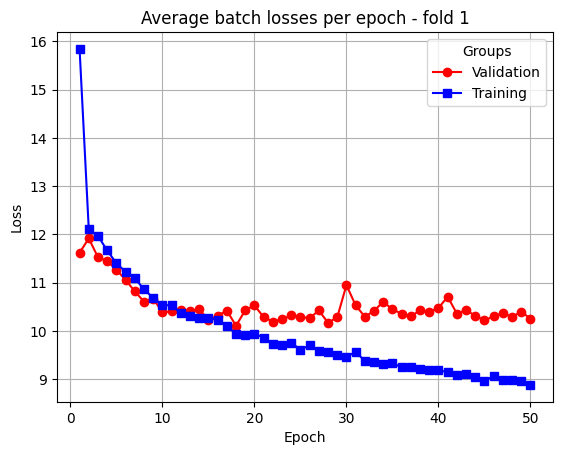

FOLD 2/4
Epoch 001 | Train Loss: 15.0390 | Val Loss: 13.5871 | 
Epoch 002 | Train Loss: 11.4418 | Val Loss: 13.3560 | 
Epoch 003 | Train Loss: 11.3625 | Val Loss: 13.8049 | 
Epoch 004 | Train Loss: 11.3535 | Val Loss: 14.2719 | 
Epoch 005 | Train Loss: 11.2748 | Val Loss: 13.3309 | 
Epoch 006 | Train Loss: 11.1950 | Val Loss: 13.7538 | 
Epoch 007 | Train Loss: 11.0394 | Val Loss: 13.6596 | 
Epoch 008 | Train Loss: 10.8490 | Val Loss: 13.4567 | 
Epoch 009 | Train Loss: 10.6412 | Val Loss: 13.8143 | 
Epoch 010 | Train Loss: 10.5564 | Val Loss: 13.8375 | 
Epoch 011 | Train Loss: 10.4431 | Val Loss: 13.9692 | 
Epoch 012 | Train Loss: 10.2620 | Val Loss: 13.3769 | 
Epoch 013 | Train Loss: 10.0883 | Val Loss: 13.5027 | 
Epoch 014 | Train Loss: 10.0309 | Val Loss: 13.5124 | 
Epoch 015 | Train Loss: 9.8571 | Val Loss: 13.7066 | 
Epoch 016 | Train Loss: 9.9245 | Val Loss: 13.7445 | 
Epoch 017 | Train Loss: 9.7514 | Val Loss: 13.7764 | 
Epoch 018 | Train Loss: 9.6764 | Val Loss: 13.3531 | 
Epoch

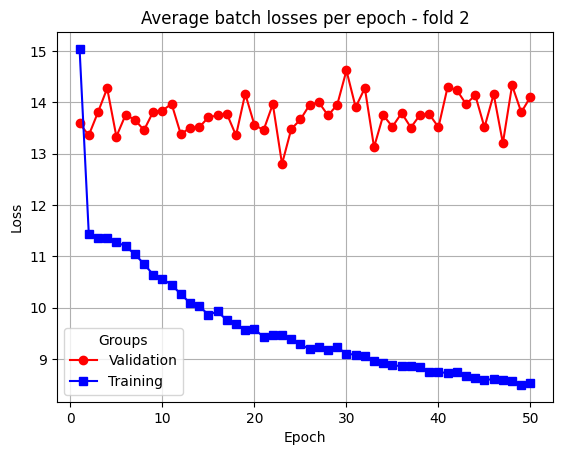

FOLD 3/4
Epoch 001 | Train Loss: 16.3231 | Val Loss: 11.7843 | 
Epoch 002 | Train Loss: 12.0119 | Val Loss: 11.6646 | 
Epoch 003 | Train Loss: 11.7815 | Val Loss: 11.3155 | 
Epoch 004 | Train Loss: 11.6635 | Val Loss: 11.0751 | 
Epoch 005 | Train Loss: 11.3664 | Val Loss: 11.0217 | 
Epoch 006 | Train Loss: 11.1639 | Val Loss: 10.7892 | 
Epoch 007 | Train Loss: 11.0664 | Val Loss: 10.6462 | 
Epoch 008 | Train Loss: 10.8546 | Val Loss: 10.7088 | 
Epoch 009 | Train Loss: 10.7794 | Val Loss: 10.6330 | 
Epoch 010 | Train Loss: 10.5618 | Val Loss: 10.5930 | 
Epoch 011 | Train Loss: 10.5184 | Val Loss: 10.4609 | 
Epoch 012 | Train Loss: 10.3871 | Val Loss: 10.5219 | 
Epoch 013 | Train Loss: 10.2521 | Val Loss: 10.8306 | 
Epoch 014 | Train Loss: 10.2223 | Val Loss: 10.4611 | 
Epoch 015 | Train Loss: 10.0782 | Val Loss: 10.4633 | 
Epoch 016 | Train Loss: 9.9852 | Val Loss: 10.5492 | 
Epoch 017 | Train Loss: 9.8975 | Val Loss: 10.5907 | 
Epoch 018 | Train Loss: 9.9343 | Val Loss: 10.4960 | 
Epoc

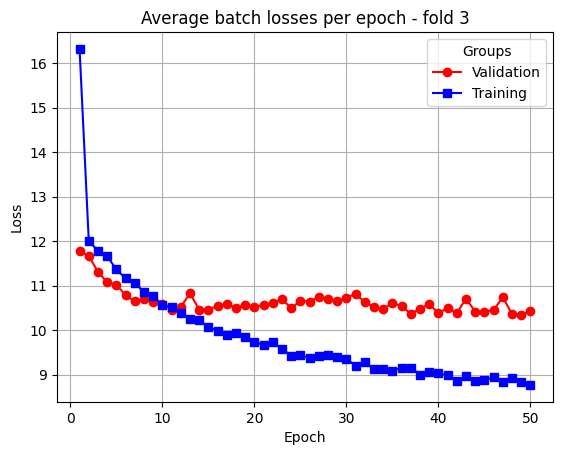

FOLD 4/4
Epoch 001 | Train Loss: 16.8472 | Val Loss: 10.5579 | 
Epoch 002 | Train Loss: 12.5289 | Val Loss: 10.4383 | 
Epoch 003 | Train Loss: 12.3466 | Val Loss: 10.3881 | 
Epoch 004 | Train Loss: 12.2553 | Val Loss: 10.6083 | 
Epoch 005 | Train Loss: 12.0962 | Val Loss: 10.0159 | 
Epoch 006 | Train Loss: 11.8862 | Val Loss: 9.9866 | 
Epoch 007 | Train Loss: 11.6166 | Val Loss: 9.8317 | 
Epoch 008 | Train Loss: 11.4750 | Val Loss: 9.6130 | 
Epoch 009 | Train Loss: 11.2778 | Val Loss: 9.8034 | 
Epoch 010 | Train Loss: 11.1440 | Val Loss: 9.5464 | 
Epoch 011 | Train Loss: 11.0725 | Val Loss: 9.3396 | 
Epoch 012 | Train Loss: 10.9180 | Val Loss: 9.2745 | 
Epoch 013 | Train Loss: 10.7445 | Val Loss: 9.3056 | 
Epoch 014 | Train Loss: 10.7125 | Val Loss: 9.0793 | 
Epoch 015 | Train Loss: 10.5763 | Val Loss: 9.3508 | 
Epoch 016 | Train Loss: 10.4303 | Val Loss: 9.2475 | 
Epoch 017 | Train Loss: 10.3869 | Val Loss: 9.2141 | 
Epoch 018 | Train Loss: 10.2924 | Val Loss: 9.1203 | 
Epoch 019 | Tr

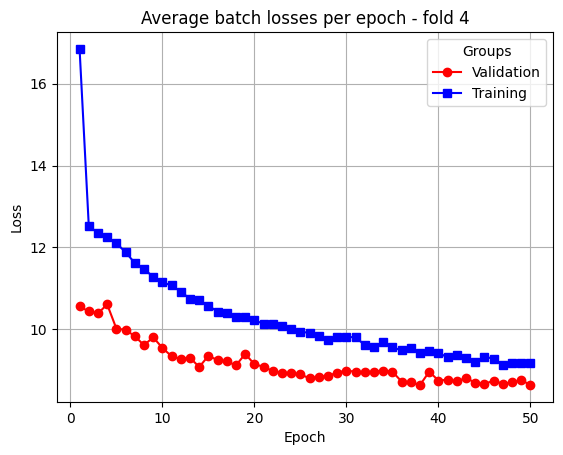


Average Scores across folds:
RMSE: train=8.6252, val=11.5006
NMSE: train=0.4524, val=0.8846


In [159]:
my_NNRegressor = NNRegressor(
    model_class=ConvNN2,
    model_parameters={},
    loss_fnc=RMSELoss(),
    batch_size = 50,
    learning_rate = 0.001,
    max_epochs = 50,
    patience = 10
)

results = cross_validate_NN(
    my_NNRegressor,
    X_train_val_folds,
    Y_train_val_folds,
    metric_fns={'RMSE': RMSE, 'NMSE': NMSE},
    verbose=3)

# Testing ensemble models

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

from config.transformers import TimeDomainTransformer
from config.validation import RMSE, NMSE, cross_validate_pipeline

In [49]:
PATH = f'/Users/marco/PROJECTS/data/'
# PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'
DATASET = 'freemoves' # change this to guided/freemoves if needed

X = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')
Y = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')

tw_extractor = TimeWindowTransformer(size = 500, step = 100)
label_extractor = LabelWindowExtractor(size = 500, step = 100)

X_windows = tw_extractor.transform(X)
Y_labels = label_extractor.transform(Y)

train_val_idx = [0,1,2,3]
test_idx = 4

X_train_val_folds = X_windows[train_val_idx]
Y_train_val_folds = Y_labels[train_val_idx]

X_test = X_windows[test_idx]
Y_test = Y_labels[test_idx]

In [50]:
baseline_guided_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_guided_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

baseline_guided_rf = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

In [51]:
import pyriemann
import pyriemann.regression
from sklearn.multioutput import MultiOutputRegressor

In [52]:
# Riemannian geometry of covariance matrices
riem1 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

riem2 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

riem3 = Pipeline(
    [
        ('feature_extraction', pyriemann.estimation.Covariances()),
        ('transformation', pyriemann.tangentspace.TangentSpace(
            metric = 'riemann',
            tsupdate = True)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

In [53]:
from config.regressors import VotingRegressor, StackingRegressor

In [54]:
voting_estimator = VotingRegressor(
    estimators = [
        baseline_guided_kr,
        baseline_guided_knn,
        baseline_guided_rf,
        riem1,
        riem2,
        riem3
    ]
)

stacking_estimator = StackingRegressor(
    estimators = [
        baseline_guided_kr,
        baseline_guided_knn,
        baseline_guided_rf,
        riem1,
        riem2,
        riem3
    ],
    end_estimator = RandomForestRegressor(
        n_estimators = 50,
        max_depth = 10)
)

In [55]:
metric_fns = {'RMSE': RMSE, 'NMSE': NMSE}

In [35]:
result = cross_validate_pipeline(voting_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)


Fold 1
RMSE: train=1.0528, val=3.5905
NMSE: train=0.0055, val=0.0664

Fold 2
RMSE: train=1.0243, val=4.5158
NMSE: train=0.0052, val=0.1033

Fold 3
RMSE: train=1.0915, val=5.3156
NMSE: train=0.0060, val=0.1334

Fold 4
RMSE: train=1.0335, val=3.7990
NMSE: train=0.0053, val=0.0728

Average Scores across folds:
RMSE: train=1.0505, val=4.3052
NMSE: train=0.0055, val=0.0940


In [25]:
result = cross_validate_pipeline(stacking_estimator, X_train_val_folds, Y_train_val_folds, metric_fns, verbose=2)

KeyboardInterrupt: 

### Generate CSV

In [56]:
from config.utils import save_to_csv

In [57]:
X_train_val = X_train_val_folds.reshape(-1, *X_train_val_folds.shape[2:])
Y_train_val = Y_train_val_folds.reshape(-1, *Y_train_val_folds.shape[2:])

In [ ]:
fname = f'submission/{DATASET}/Y_predicted_voting.csv'

voting_estimator.fit(X_train_val, Y_train_val)
Y_pred = voting_estimator.predict(X_test)

save_to_csv(Y_pred, fname)

In [39]:
fname = f'submission/{DATASET}/Y_predicted_stacking.csv'

stacking_estimator.fit(X_train_val, Y_train_val)
Y_pred = stacking_estimator.predict(X_test)

save_to_csv(Y_pred, fname)

In [58]:
fname = f'submission/{DATASET}/Y_true.csv'
save_to_csv(Y_test, fname)